# 0. Imports and standard functions

In [1]:
# importing packages to be used in the notebook
import numpy as np
import numba
from numba import njit
import warnings
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator

warnings.simplefilter('always', RuntimeWarning)

# plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
# plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'font.size': 15})
plt.rcParams['lines.linewidth'] = 2.0
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 15}
plt.rc('font', **font)
plt.rc('text', usetex=True)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#006BA2','#DB444B','#000000','#EBB434',
                                                    '#3EBCD2','#379A8B','#9A607F', '#B4BA39', '#754C24']) 

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
from sequence_jacobian import interpolate
from sequence_jacobian import drawdag
from sequence_jacobian import JacobianDict
from scipy.interpolate import interp1d

from types import SimpleNamespace
from tabulate import tabulate

# importing own modules
import hh_housing_v3 # contains the single EGM step 
import utils # contains different useful functions for the model

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

In [3]:
T = 300
@njit
def manipulate_separable(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

def E_sticky_exp(theta, T=T, sticky_info=False):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    if sticky_info:
        return E
    else:
        E = np.triu(E, +1) + np.tril(np.ones((T, T)))
        return E
    
def manipulate_jac(xi, Js, input_list, output_list, hh_name):
    jac_ = {}
    for output in output_list:
        jac_[output] = {}
        for input in input_list:
            jac_[output][input] = manipulate_separable(Js[hh_name][output][input], E_sticky_exp(xi))
    return jac_

def inattention_irf(xi, model_ss, hh_block, model, hh_name, input_list, output_list, unknowns, targets, dr):
    Js = {hh_name: hh_block.jacobian(model_ss, inputs=input_list, outputs=output_list, T=T)}

    jac_ = manipulate_jac(xi, Js, input_list, output_list, hh_name)

    Js_myopic = {hh_name: JacobianDict(jac_, inputs=input_list, outputs=output_list, name='hank')}

    irfs = (model.solve_jacobian(model_ss, unknowns=unknowns, targets=targets, T=T,
                                                Js=Js_myopic, inputs=['epsm'], 
                                                outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
                                                        'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})
    
    return irfs, Js_myopic

def consumption_decomp(Js, irfs, hh_name):
    # empty namespace to store decompositions
    decomp = SimpleNamespace()

    # empty dictionary to store decompositions
    decomp_dict = {}

    input_list_decomp = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w']
    for k in input_list_decomp:
        setattr(decomp, f'dC_d{k}', Js[hh_name]['C_BHAT'][k] @ irfs[k])

    decomp_dict = vars(decomp)

    tot_response = 0

    for (key, value) in decomp_dict.items():
        tot_response += value

    decomp_dict['housing'] = decomp.dC_dqh + decomp.dC_dqh_lag
    decomp_dict['indirect'] = decomp.dC_dN + decomp.dC_dTax + decomp.dC_dDiv + decomp.dC_dw
    decomp_dict['direct'] = decomp.dC_dr
    decomp_dict['total'] = tot_response

    assert np.allclose(decomp_dict['total'], irfs['C_BHAT']), f"Total response does not match the IRF"

    return decomp_dict

## Plot functions

In [32]:
def plot_decomp(nrows, ncols, decomp_dict, irfs, H = 17, plot_together = False):
    fig, ax = plt.subplots(nrows, ncols, figsize=(16*ncols/3,12*nrows/3), sharex = True, sharey = True)

    if nrows != 1 and ncols != 1:
        ax = ax.flatten()

    plot_total = False

    ii = 0
    for key, value in decomp_dict.items():
        ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], label='Housing effect')
        ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], label='Indirect effect')
        ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], label='Direct effect')
        ax[ii].set_title(key)

        ax[ii].set_xlabel('Quarters')
        ax[ii].set_ylabel('Percent from steady state')
        ax[ii].xaxis.set_major_locator(MultipleLocator(4))
        ax[ii].set_xlim(0, 16)
        ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
        ax[ii].legend(fontsize=10, frameon=False) #, loc='center right', bbox_to_anchor=(1, 0.44)

        ii += 1

    if plot_together:
        jj = 0
        
        for key, value in decomp_dict.items():
            if jj == 0:
                ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], label=f'{key}', color = '#006BA2')
                ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], label=f'{key}', color = '#DB444B')
                ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], label=f'{key}', color = '#000000')
            elif jj == 1: 
                ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], color = '#006BA2', ls = 'dashdot', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], color = '#DB444B', ls = 'dashdot', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], color = '#000000', ls = 'dashdot', label=f'{key}')
            else:
                ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], color = '#006BA2', ls = 'dotted', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], color = '#DB444B', ls = 'dotted', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], color = '#000000', ls = 'dotted', label=f'{key}')

            jj += 1
            ax[ii].legend(fontsize=10, frameon=False, ncols = 3, loc='upper center', bbox_to_anchor=(0.5, -0.1))
            ax[ii].set_title('Comparision')

    plt.show()

# 1. Baseline calibration of the model

In [5]:
hh = hh_housing_v3.hh_housecons_sep
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])
hh2 = hh1.add_hetoutputs([utils.compute_mpc])

hh_name = hh.name

blocks_ss = [hh2, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
            utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]

hank_ss = create_model(blocks_ss, name="Housing HANK SS")

blocks = [hh2, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
            utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]

hank = create_model(blocks, name="Housing HANK")

T = 300
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']
exogenous = ['rstar', 'Z', 'gamma']

ss = {}
model = {}

In [6]:
cali_main = {'gamma': 0.8, 'qh': 1.61*4, 'sigma': 2.0, 'alpha': 0.18, 'bmax': 45, 'rhom': 0.89, 'omega': 0.5, 'q': 0.01,
             'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'epsm': 0.0,
             'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
             'kappa': 0.0160685, 'rstar': 0.03/4, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}

# cali_main['alpha'] = 0.13
cali_main['alpha'] = 0.05


unknowns_ss = {'beta_hi': 0.970, 'varphi': 0.836, 'theta': 0.061, 'dbeta': 0.053}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0, 'MPC': 0.12}

ss['baseline'] = hank_ss.solve_steady_state(cali_main, unknowns_ss, targets_ss, solver="hybr")
model['baseline'] = hank.steady_state(ss['baseline'])

cali_new = cali_main.copy()
cali_new['qh'] = 2.44*4
ss['qh10'] = hank_ss.solve_steady_state(cali_new, unknowns_ss, targets_ss, solver="hybr")
model['qh10'] = hank.steady_state(ss['qh10'])

In [ ]:
compute_differentmpc = True
if compute_differentmpc:
    cali_diffmpc = cali_main.copy()
    cali_diffmpc['qh'] = 2.44*4
    cali_diffmpc['dbeta'] = ss['baseline']['dbeta']

    unknowns_ss_diffmpc = {'beta_hi': 0.970, 'varphi': 0.836, 'theta': 0.092}
    targets_ss_diffmpc = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

    ss['diffmpc'] = hank_ss.solve_steady_state(cali_diffmpc, unknowns_ss_diffmpc, targets_ss_diffmpc, solver="hybr")
    model['diffmpc'] = hank.steady_state(ss['diffmpc'])

In [45]:
compute_highgam = True
if compute_highgam:
    unknowns_ss = {'beta_hi': 0.970, 'varphi': 0.836, 'theta': 0.061, 'dbeta': 0.053}
    targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0, 'MPC': 0.15}
    ss['highmpc'] = hank_ss.solve_steady_state(cali_main, unknowns_ss, targets_ss, solver="hybr")
    model['highmpc'] = hank.steady_state(ss['highmpc'])

In [57]:
model['highmpc'].internals[hh_name].keys()

print(model['highmpc'].internals[hh_name]['e_grid']*model['highmpc'].internals[hh_name]['pi_pdf'])

[0.02289456 0.16819479 0.30891065 0.02289456 0.16819479 0.30891065]


In [8]:
print(f"beta_hi: {ss['baseline']['beta_hi']:.3f}, theta: {ss['baseline']['theta']:.3f}, varphi: {ss['baseline']['varphi']:.3f}, dbeta: {ss['baseline']['dbeta']:.3f}")
# print(f"MPC: {ss['baseline']['MPC']:.3f}, qh: {ss['baseline']['qh']:.3f}, qh10: {ss['qh10']['qh']:.3f}")  

print(f"beta_hi: {ss['qh10']['beta_hi']:.3f}, theta: {ss['qh10']['theta']:.3f}, varphi: {ss['qh10']['varphi']:.3f}, dbeta: {ss['qh10']['dbeta']:.3f}")
print(f"beta_hi: {ss['diffmpc']['beta_hi']:.3f}, theta: {ss['diffmpc']['theta']:.3f}, varphi: {ss['diffmpc']['varphi']:.3f}, dbeta: {ss['diffmpc']['dbeta']:.3f}")
print(f"MPC baseline: {ss['baseline']['MPC']:.3f}, MPC hw: {ss['qh10']['MPC']:.3f}, MPC diffmpc: {ss['diffmpc']['MPC']:.3f}")

beta_hi: 0.967, theta: 0.056, varphi: 0.835, dbeta: 0.039
beta_hi: 0.981, theta: 0.092, varphi: 0.835, dbeta: 0.086
beta_hi: 0.977, theta: 0.082, varphi: 0.835, dbeta: 0.039
MPC baseline: 0.120, MPC hw: 0.120, MPC diffmpc: 0.086


# 2. Figures for steady state

In [7]:
H = 10

In [52]:
use_model = model['baseline']

TT = 300
sigma_qh = use_model['qh']*0.01
rho_qh = 0.0
qh = sigma_qh*rho_qh** np.arange(TT)
qh_lag = np.zeros(TT)

for i in range(1, TT):
    qh_lag[i] = qh[i-1]

qh_only = hh1.impulse_linear(use_model, {'qh': qh}, outputs = ['C_BHAT'],internals=[hh_name])
qhlag_only = hh1.impulse_linear(use_model, {'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])
tot = hh1.impulse_nonlinear(use_model, {'qh': qh, 'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])

percent_c = 100*tot['C_BHAT']/use_model['C_BHAT']
percent_qh = 100*qh/use_model['qh']
elasticity = percent_c/percent_qh[0]

M_labor = hh2.jacobian(use_model, inputs=['w'], outputs=['C_BHAT'], T=T)['C_BHAT','w']
M_labor_higmpc = hh2.jacobian(model['highmpc'], inputs=['w'], outputs=['C_BHAT'], T=T)['C_BHAT','w']
impcs = M_labor[:, 0]
impcs_highmpc = M_labor_higmpc[:, 0]

In [9]:
use_model = model['qh10']

TT = 300
sigma_qh = use_model['qh']*0.01
rho_qh = 0.0
qh = sigma_qh*rho_qh** np.arange(TT)
qh_lag = np.zeros(TT)

for i in range(1, TT):
    qh_lag[i] = qh[i-1]

qh_only = hh1.impulse_linear(use_model, {'qh': qh}, outputs = ['C_BHAT'],internals=[hh_name])
qhlag_only = hh1.impulse_linear(use_model, {'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])
tot = hh1.impulse_nonlinear(use_model, {'qh': qh, 'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])

percent_c = 100*tot['C_BHAT']/use_model['C_BHAT']
percent_qh = 100*qh/use_model['qh']
elasticity_hw = percent_c/percent_qh[0]

In [10]:
use_model = model['diffmpc']

TT = 300
sigma_qh = use_model['qh']*0.01
rho_qh = 0.0
qh = sigma_qh*rho_qh** np.arange(TT)
qh_lag = np.zeros(TT)

for i in range(1, TT):
    qh_lag[i] = qh[i-1]

qh_only = hh1.impulse_linear(use_model, {'qh': qh}, outputs = ['C_BHAT'],internals=[hh_name])
qhlag_only = hh1.impulse_linear(use_model, {'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])
tot = hh1.impulse_nonlinear(use_model, {'qh': qh, 'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])

percent_c = 100*tot['C_BHAT']/use_model['C_BHAT']
percent_qh = 100*qh/use_model['qh']
elasticity_diffmpc = percent_c/percent_qh[0]

### Figure 1: iMPC out of income

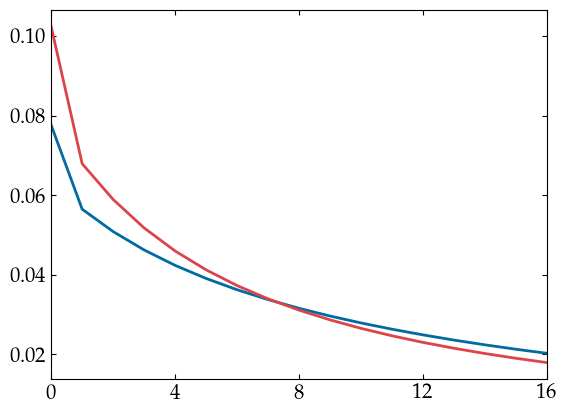

In [53]:
plt.plot(impcs[:H], label='MPC out of income')
plt.plot(impcs_highmpc[:H], label='MPC out of income high mpc')
plt.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
# Get the current Axes object
ax = plt.gca()

# Set the major locator for the x-axis
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.set_xlim(0, H -1)

plt.show()

### Figure 2: Average MPC out of housing

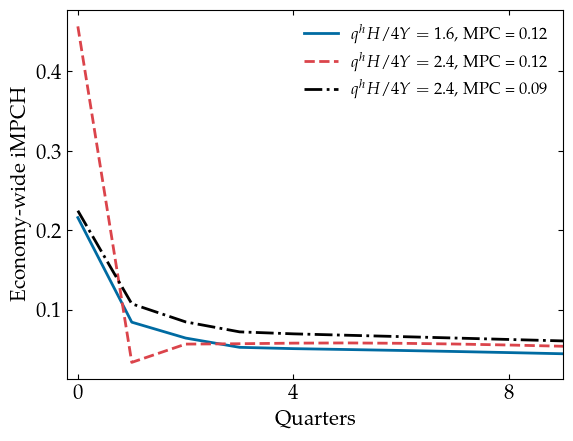

In [12]:
fig, ax = plt.subplots()

lw = 2.0
ax.plot(elasticity[:H], label=fr"$q^hH/4Y = 1.6$, MPC = {ss['baseline']['MPC']:.2f}", linewidth=lw)
ax.plot(elasticity_hw[:H], label=fr"$q^hH/4Y = 2.4$, MPC = {ss['qh10']['MPC']:.2f}", linestyle='dashed', linewidth=lw)
ax.plot(elasticity_diffmpc[:H], label=fr"$q^hH/4Y = 2.4$, MPC = {ss['diffmpc']['MPC']:.2f}", linestyle='dashdot', linewidth=lw)
# plt.title('MPC/Elasticity out of housing wealth')
ax.set_xlabel('Quarters')
ax.set_ylabel('Economy-wide iMPCH')
ax.legend(frameon=False, fontsize=12)
# print(f"Elasticity at 0: {elasticity[0]:.3f}")
# print(f"MPC at 0: {tot['C_BHAT'][0]/qh[0]:.3f}")
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)

ax.xaxis.set_major_locator(MultipleLocator(4))
ax.set_xlim(-0.2, H - 1)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'iMPCh_v001.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Figure 4: MPCH over the distribution

In [13]:
b_grid = model['baseline'].internals[hh_name]['b_bhat_grid']
z_grid = model['baseline'].internals[hh_name]['z_grid']
h_grid = model['baseline'].internals[hh_name]['h_bhat_grid']

bdmargdist = np.sum(model['baseline'].internals[hh_name]['D'], axis=0)
b_margdist = np.sum(bdmargdist,axis=1) # sum out housing
h_margdist = np.sum(bdmargdist,axis=0) # sum out bonds
bmargcum = np.cumsum(b_margdist)
hmargcum = np.cumsum(h_margdist)
index_b = np.argmin(np.abs(bmargcum - 0.5))
print(f"Median b: {b_grid[index_b]:.3f} at index {index_b}")
index_h = np.argmin(np.abs(hmargcum - 0.5))
print(f"Median h: {h_grid[index_h]:.3f} at index {index_h}")

Median b: 1.438 at index 18
Median h: 0.693 at index 30


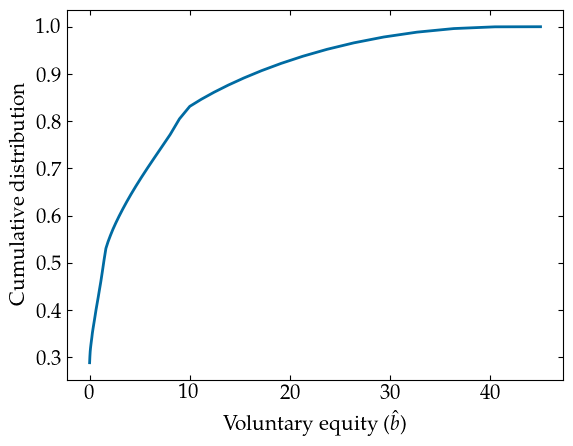

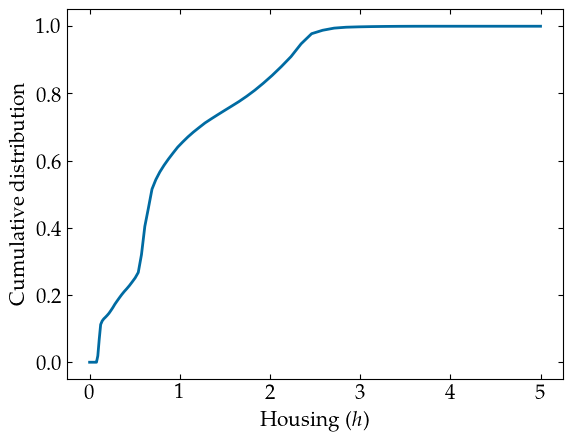

In [14]:
plt.plot(b_grid, bmargcum, label='b')
plt.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
plt.xlabel(r'Voluntary equity ($\hat{b}$)')
plt.ylabel('Cumulative distribution')
plt.show()

plt.plot(h_grid, hmargcum, label='b')
plt.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
plt.xlabel(r'Housing ($h$)')
plt.ylabel('Cumulative distribution')
plt.show()

### Figure 4: MPCH over the distribution

Mean MPC: 0.018
Mean MPC: 0.120


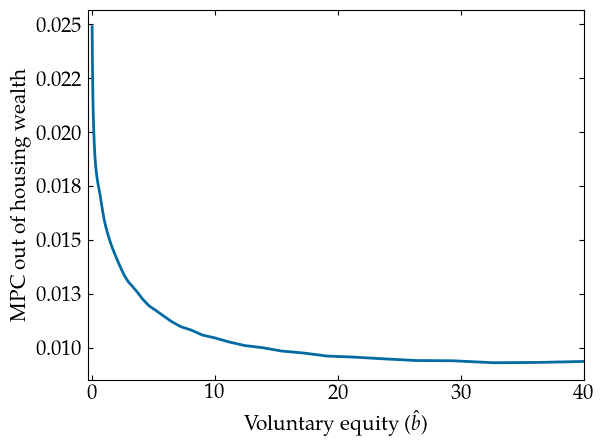

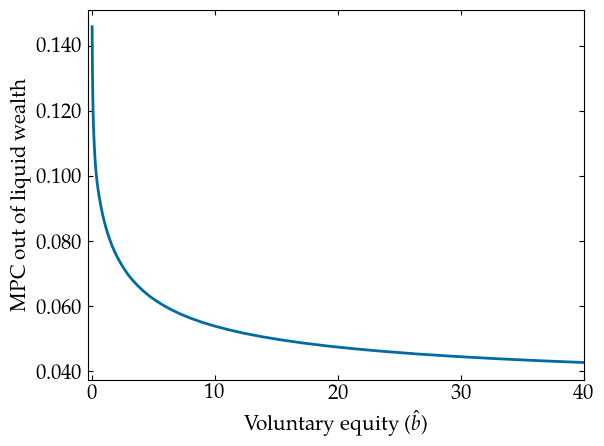

In [15]:
MPCH, mean_MPC = utils.calc_mpch(model['baseline'], hh_name)
print(f"Mean MPC: {mean_MPC:.3f}")

MPC, mean_MPC = utils.calc_mpc(model['baseline'], hh_name)
print(f"Mean MPC: {mean_MPC:.3f}")

z_idx = 1
h_idx = 10
b_idx = 10
# plt.plot(b_grid, MPCH[z_idx,:,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
# plt.plot(h_grid, model['baseline'].internals[hh_name]['c_bhat'][z_idx,b_idx,:], label='c')
# plt.plot(b_grid, model['baseline'].internals[hh_name]['c_bhat'][z_idx,:,index_h], label='c')

def format_func(value, tick_number):
    return f'{value:.3f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

fig, ax = plt.subplots()
ax.plot(b_grid, MPCH[z_idx,:,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax.set_xlabel(r'Voluntary equity ($\hat{b}$)')
ax.set_ylabel('MPC out of housing wealth')
ax.set_xlim(-0.35, 40)
ax.yaxis.set_major_formatter(formatter)
# ax.grid(True, axis='y')
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'MPCH_v001.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

fig, ax = plt.subplots()
ax.plot(b_grid[:-1], MPC[z_idx,:-1,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
# plt.legend(frameon=False)
ax.set_xlabel(r'Voluntary equity ($\hat{b}$)')
ax.set_ylabel('MPC out of liquid wealth')
ax.set_xlim(-0.35, 40)
ax.yaxis.set_major_formatter(formatter)
# ax.grid(True, axis='y')
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'MPC_v001.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

# 3. Figures for transition dynamics

In [9]:
input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p']
output_list = ['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI', 'UCE_BHAT']

sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r

In [10]:
H = 17
interval = 2
devss = ['Y', 'qh', 'C_BHAT', 'w', 'N', 'Div', 'Tax', 'CHI']

# Function to format y-axis labels with the same number of digits
def format_func(value, tick_number):
    return f'{value:.1f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

In [11]:
real_rigid = 5
calvo_keep = 0.75 #0.926
calvo_change = 1 - calvo_keep

beta = model['baseline']['omega'] * model['baseline']['beta_hi'] +\
      (1 - model['baseline']['omega']) * (model['baseline']['beta_hi'] - model['baseline']['dbeta'])

kappa = 1 / (1 + real_rigid) * (calvo_change * (1 - beta*calvo_keep)/(calvo_keep))
print(kappa)

0.016068527411913076


In [12]:
# irfs = {}

# xi = 0.99 # persistence of expectations
# rhom = 0.89
# # kappa = 0.01
# model['baseline']['rhom'] = rhom
# model['baseline']['kappa'] = kappa

# model['qh10']['rhom'] = rhom
# model['qh10']['kappa'] = kappa

# model_ss = model['baseline'] # steady state for qh = (baseline)
# model_hw = model['qh10'] # steady state for qh = 10

# Js = {hh_name: hh2.jacobian(model_ss, inputs=input_list, outputs=output_list, T=T)}
# Js_hw = {hh_name: hh2.jacobian(model_hw, inputs=input_list, outputs=output_list, T=T)}

# jac_ = manipulate_jac(xi, Js, input_list, output_list, hh_name)
# jac_hw = manipulate_jac(xi, Js_hw, input_list, output_list, hh_name)

# Js_myopic = {hh_name: JacobianDict(jac_, inputs=input_list, outputs=output_list, name='hank')}
# Js_myopic_hw = {hh_name: JacobianDict(jac_hw, inputs=input_list, outputs=output_list, name='hank')}

# irfs['fire'] = (hank.solve_jacobian(model_ss, unknowns=unknowns, targets=targets, T=T, inputs=['epsm'], 
#                                               outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
#                                                        'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

# irfs['inatt'] = (hank.solve_jacobian(model_ss, unknowns=unknowns, targets=targets, T=T,
#                                               Js=Js_myopic, inputs=['epsm'], 
#                                               outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
#                                                        'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

# irfs['inatt_hw'] = (hank.solve_jacobian(model_hw, unknowns=unknowns, targets=targets, T=T,
#                                               Js=Js_myopic_hw, inputs=['epsm'], 
#                                               outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
#                                                        'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

In [39]:
Js_dict = {}    # empty dictionary to store Jacobians
irfs = {}       # empty dictionary to store impulse responses

xi = 0.99 # persistence of expectations
irfs['fire'], Js_dict['fire'] = inattention_irf(0, model['baseline'], hh2, hank, hh_name, 
                                    input_list, output_list, unknowns, targets, dr)

irfs['inatt'], Js_dict['inatt'] = inattention_irf(xi, model['baseline'], hh2, hank, hh_name, 
                                                    input_list, output_list, unknowns, targets, dr)

irfs['inatt_hw'], Js_dict['inatt_hw'] = inattention_irf(xi, model['qh10'], hh2, hank, hh_name, 
                                                    input_list, output_list, unknowns, targets, dr)

In [46]:
irfs['highmpc'], Js_dict['highmpc'] = inattention_irf(xi, model['highmpc'], hh2, hank, hh_name, 
                                                    input_list, output_list, unknowns, targets, dr)

In [14]:
if compute_differentmpc:
    # model['diffmpc']['rhom'] = rhom
    # model['diffmpc']['kappa'] = kappa

    irfs['diffmpc'], Js_dict['diffmpc'] = inattention_irf(xi, model['diffmpc'], hh2, hank, hh_name, 
                                      input_list, output_list, unknowns, targets, dr)

    # Js_diffmpc = {hh_name: hh2.jacobian(model['diffmpc'], inputs=input_list, outputs=output_list, T=T)}
    # jac_diffmpc = manipulate_jac(xi, Js_diffmpc, input_list, output_list, hh_name)
    # Js_myopic_diffmpc = {hh_name: JacobianDict(jac_diffmpc, inputs=input_list, outputs=output_list, name='hank')}
    # irfs['diff_mpc'] = (hank.solve_jacobian(model['diffmpc'], unknowns=unknowns, targets=targets, T=T,
    #                                           Js=Js_myopic_diffmpc, inputs=['epsm'], 
    #                                           outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
    #                                                    'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

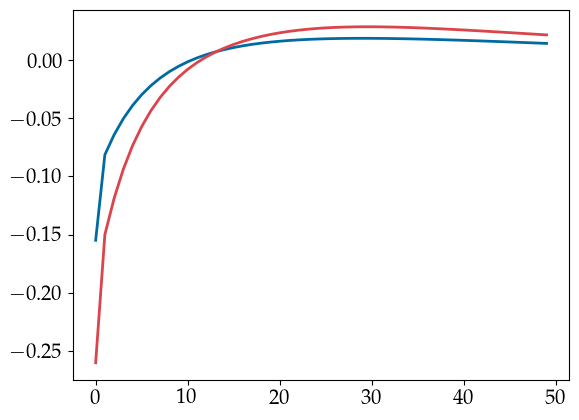

In [49]:
rho = 0.9
dr_jac = -0.01*rho**np.arange(T)
i = 0
H_jac = 50
plt.plot(Js_dict['inatt'][hh_name]['C_BHAT']['r'][:H_jac,i])
plt.plot(Js_dict['highmpc'][hh_name]['C_BHAT']['r'][:H_jac,i])
# plt.plot(Js_dict['inatt_hw'][hh_name]['C_BHAT']['r'][:H_jac,i])
# plt.plot(Js_dict['fire'][hh_name]['C_BHAT']['r'][:H_jac,i])

# plt.plot((Js[hh_name]['C_BHAT']['r']@dr_jac)[:H_jac])
# plt.plot((Js_myopic[hh_name]['C_BHAT']['r']@dr_jac)[:H_jac])
# plt.axvline(x=i, color='black', linestyle='--')
# plt.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
# plt.title(r'Jacobian of C wrt. interest rate ($\mathcal{J}^{C,r}$)')

### Figure 1: Comparing the response with and without inattention

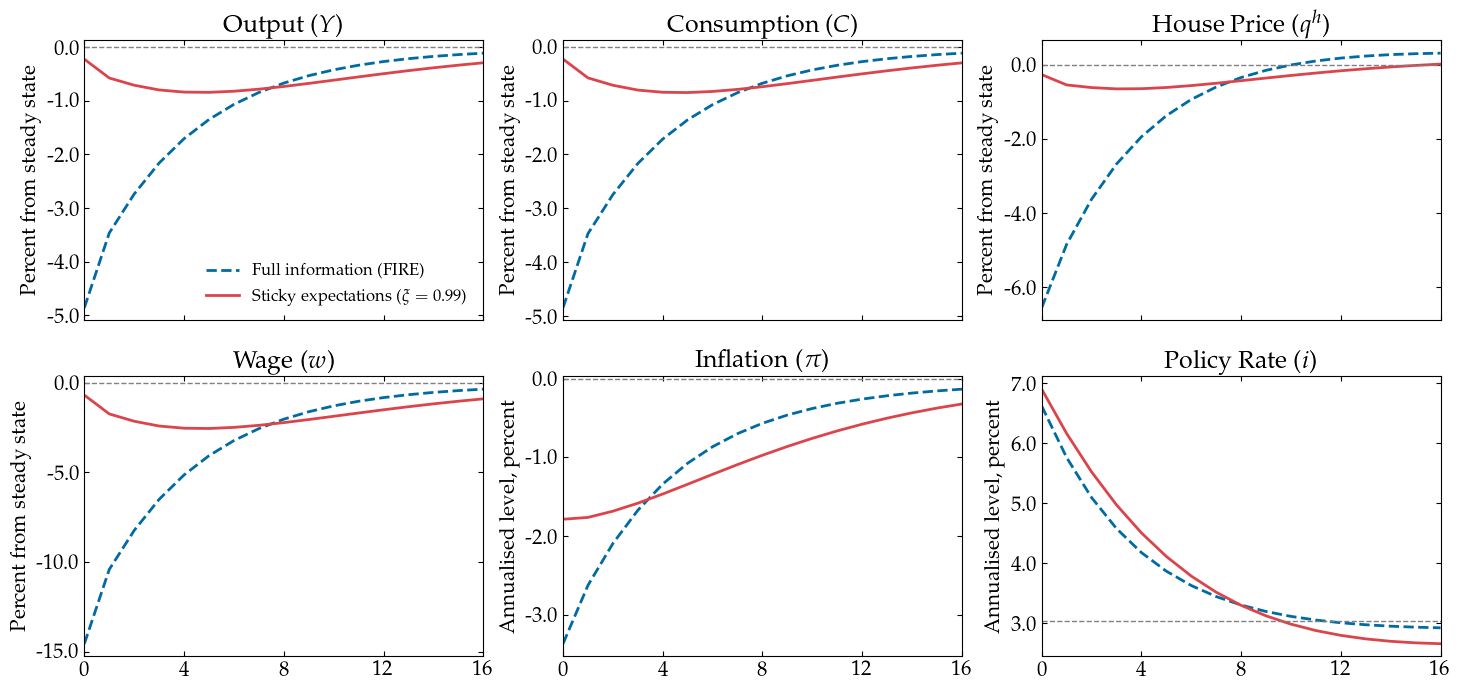

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(17.5,12*2/3), sharex = True)
ax = ax.flatten()

irf1 = irfs['fire']
irf2 = irfs['inatt']
model_ss = model['baseline']

irf3 = irfs['inatt_hw']
model_hw = model['qh10']

var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'qh': r'House Price ($q^h$)', 
            'w': r'Wage ($w$)', 'pi': r'Inflation ($\pi$)', 'i': r'Policy Rate ($i$)'}

for i, (key, value) in enumerate(var_name.items()):   
    if key in devss:   
        ax[i].plot(100*(irf1[key][:H]/model_ss[key]), linewidth=2, linestyle='--')
        ax[i].plot(100*(irf2[key][:H]/model_ss[key]), linewidth=2)
        # ax[i].plot(100*(irf3[key][:H]/model_hw[key]), linewidth=2)
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + model_ss[key] +irf1[key][:H])**4-1), linewidth=2, linestyle='--')
        ax[i].plot(100*((1 + model_ss[key] +irf2[key][:H])**4-1), linewidth=2)
        ax[i].axhline(y=100*((1 + model_ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    if i == 0:
        ax[i].legend(['Full information (FIRE)',fr'Sticky expectations ($\xi =$ {xi})'], fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1)
    
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'MainModelIrf_v3.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Figure 2: Comparing with empirical IRFs

In [16]:
# Define the path to the Excel file
subfolder = 'Misc'
filename = 'rrshockirfs_v5.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)

# Load the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name='gamma', header = None)

col_name = ['i', 'C_BHAT', 'qh', 'Y', 'pi', 'Investment', 'w', 'Mortgage', 'Rent']
df.columns = col_name

bounds_name = ['lb', 'ub']
col_name_bands = []
for i in bounds_name:
    for j in col_name:
        col_name_bands.append(f'{i}_{j}')
df_bands = pd.read_excel(file_path, sheet_name='gammabands', header = None)
df_bands.columns = col_name_bands

filename = 'rrshockirfs_v5_68bands.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)
df_bands68 = pd.read_excel(file_path, sheet_name='gammabands', header = None)
df_bands68.columns = col_name_bands

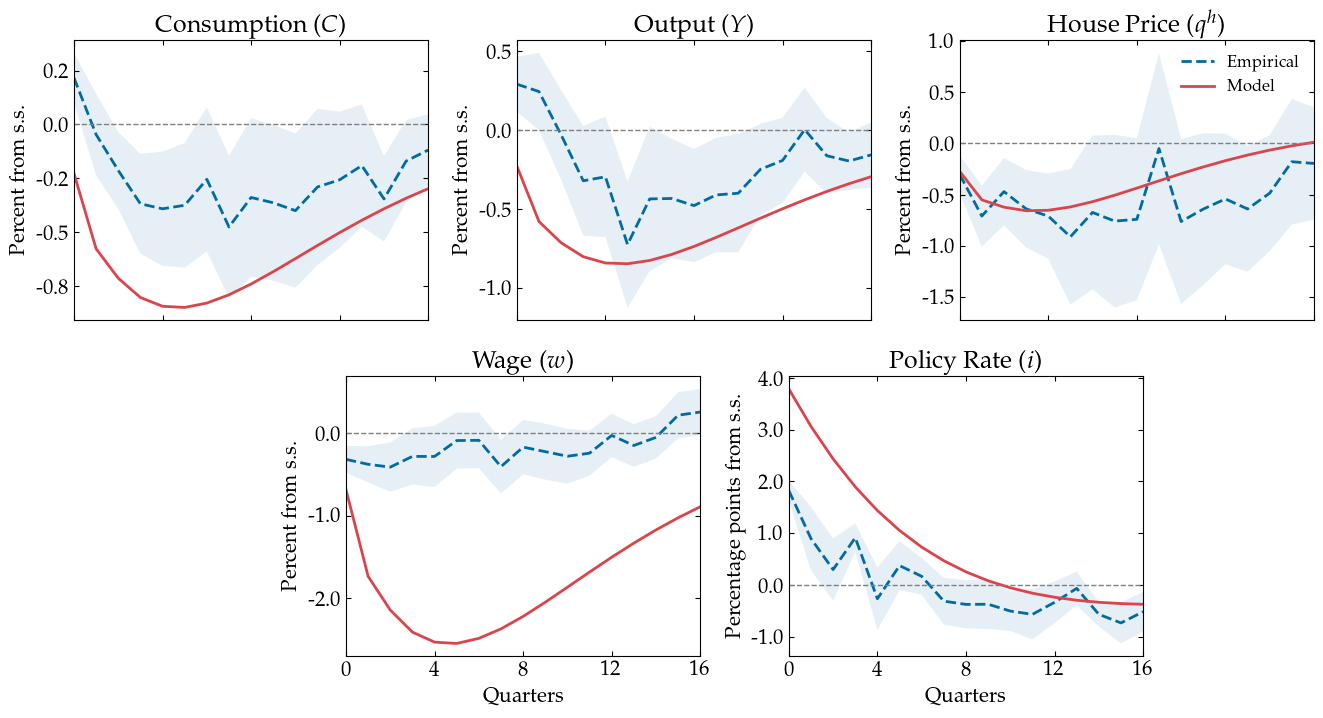

In [17]:
irf2 = irfs['inatt']
model_ss = model['baseline']

fig, ax = plt.subplots(2, 3, figsize=(16*3/3,8), sharex=True)
ax = ax.flatten()

var_name = {'C_BHAT': r'Consumption ($C$)', 'Y': 'Output ($Y$)', 'qh': 'House Price ($q^h$)', 
            'w': r'Wage ($w$)', 'i': r'Policy Rate ($i$)'}


for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*df[key][:H], ls = '--', linewidth=2, color = '#006BA2', label = 'Empirical')
    ax[i].fill_between(range(H), 100*df_bands[f"lb_{key}"][:H], 100*df_bands[f"ub_{key}"][:H], 
                       alpha = 0.1, color = '#006BA2', edgecolor = None)

    if key in devss:   
        ax[i].plot(100*(irf2[key][:H]/model_ss[key]), linewidth=2, color = '#DB444B', label = 'Model')
    else:
        ax[i].plot(100*((1 + irf2[key][:H])**4-1), linewidth=2, color = '#DB444B', label = 'Model')

    ax[i].set_title(var_name[key])
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].set_xlim(0, 16)
    ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))

    if key != 'i':
        ax[i].set_ylabel('Percent from s.s.')
    else:
        ax[i].set_ylabel('Percentage points from s.s.')

    if i == 3 or i == 4:
        ax[i].set_xlabel('Quarters')

    if i == 2:
        ax[i].legend(fontsize=12, frameon=False)

ax[5].axis('off')
fig.subplots_adjust(hspace=0.2, wspace=0.25)
for i in range(3, 5):
    pos = ax[i].get_position()
    ax[i].set_position([pos.x0 + 0.17, pos.y0, pos.width, pos.height])

plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'ModelEmpiricalComparision_v5.pdf'), dpi=1000, bbox_inches='tight')

### Figure 3: Decomposing the consumption response

dict_keys(['inatt', 'inatt_hw', 'diffmpc'])
dict_keys(['inatt', 'inatt_hw', 'diffmpc'])


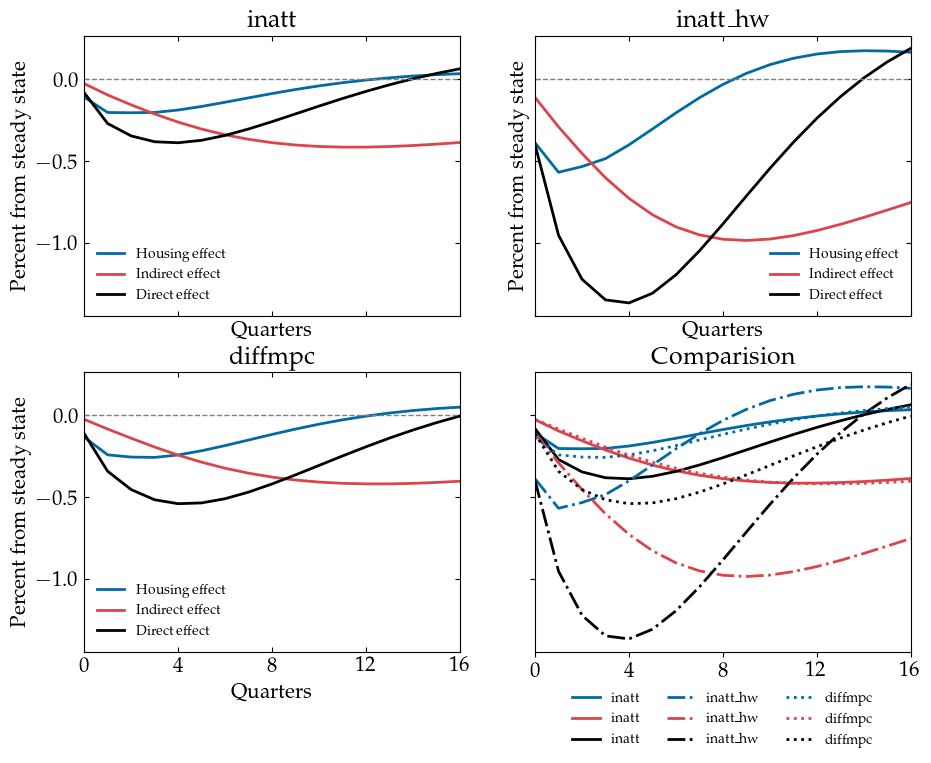

In [33]:
c_decomp = {}
c_decomp['inatt'] = consumption_decomp(Js_dict['inatt'], irfs['inatt'], hh_name)
c_decomp['inatt_hw'] = consumption_decomp(Js_dict['inatt_hw'], irfs['inatt_hw'], hh_name)
c_decomp['diffmpc'] = consumption_decomp(Js_dict['diffmpc'], irfs['diffmpc'], hh_name)
print(c_decomp.keys())

model_decomp = model.copy() # copy the model dictionary to match the keys
model_decomp['inatt'] = model_decomp.pop('baseline')
model_decomp['inatt_hw'] = model_decomp.pop('qh10')
model_decomp['diffmpc'] = model_decomp.pop('diffmpc')
print(model_decomp.keys())
plot_decomp(2, 2, c_decomp, model_decomp, H = 17, plot_together=True)

In [25]:
# empty namespace to store decompositions
decomp = SimpleNamespace()
decomp.baseline = SimpleNamespace()
decomp.hw = SimpleNamespace()

# empty namespace to store irfs
irf = SimpleNamespace()
irf.baseline = SimpleNamespace()
irf.hw = SimpleNamespace()

input_list_decomp = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w']
for k in input_list_decomp:
    setattr(decomp.baseline, f'dC_d{k}', Js_myopic[hh_name]['C_BHAT'][k] @ irfs['inatt'][k])
    setattr(decomp.hw, f'dC_d{k}', Js_myopic_hw[hh_name]['C_BHAT'][k] @ irfs['inatt_hw'][k])

if compute_differentmpc:
    decomp.diffmpc = SimpleNamespace()
    irf.diffmpc = SimpleNamespace()
    for k in input_list_decomp:
        setattr(decomp.diffmpc, f'dC_d{k}', Js_myopic_diffmpc[hh_name]['C_BHAT'][k] @ irfs['diff_mpc'][k])

decomp_dict_baseline = vars(decomp.baseline)
decomp_dict_hw = vars(decomp.hw)

tot_baseline = 0
tot_hw = 0

for (key, value) in decomp_dict_baseline.items():
    tot_baseline += value

for (key, value) in decomp_dict_hw.items():
    tot_hw += value

qh_baseline = decomp.baseline.dC_dqh + decomp.baseline.dC_dqh_lag
qh_hw = decomp.hw.dC_dqh + decomp.hw.dC_dqh_lag
indirect_baseline = decomp.baseline.dC_dN + decomp.baseline.dC_dTax + decomp.baseline.dC_dDiv + decomp.baseline.dC_dw
indirect_hw = decomp.hw.dC_dN + decomp.hw.dC_dTax + decomp.hw.dC_dDiv + decomp.hw.dC_dw
direct_baseline = decomp.baseline.dC_dr
direct_hw = decomp.hw.dC_dr

assert np.allclose(tot_baseline/model['baseline']['C_BHAT'], irfs['inatt']['C_BHAT']/model['baseline']['C_BHAT'])
assert np.allclose(tot_hw/model['qh10']['C_BHAT'], irfs['inatt_hw']['C_BHAT']/model['qh10']['C_BHAT'])

if compute_differentmpc:
    decomp_dict_diffmpc = vars(decomp.diffmpc)
    tot_diffmpc = 0 

    for (key, value) in decomp_dict_diffmpc.items():
        tot_diffmpc += value

    qh_diffmpc = decomp.diffmpc.dC_dqh + decomp.diffmpc.dC_dqh_lag
    indirect_diffmpc = decomp.diffmpc.dC_dN + decomp.diffmpc.dC_dTax + decomp.diffmpc.dC_dDiv + decomp.diffmpc.dC_dw
    direct_diffmpc = decomp.diffmpc.dC_dr

    qh_diffmpc_share = qh_diffmpc/tot_diffmpc
    indirect_diffmpc_share = indirect_diffmpc/tot_diffmpc
    direct_diffmpc_share = direct_diffmpc/tot_diffmpc

    qh_diffmpc_cum = np.cumsum(qh_diffmpc) / np.cumsum(tot_diffmpc)
    indirect_diffmpc_cum = np.cumsum(indirect_diffmpc) / np.cumsum(tot_diffmpc)
    direct_diffmpc_cum = np.cumsum(direct_diffmpc) / np.cumsum(tot_diffmpc)

    assert np.allclose(tot_diffmpc/model['diffmpc']['C_BHAT'], irfs['diff_mpc']['C_BHAT']/model['diffmpc']['C_BHAT'])

qh_baseline_share = qh_baseline/tot_baseline
indirect_baseline_share = indirect_baseline/tot_baseline
direct_baseline_share = direct_baseline/tot_baseline

qh_hw_share = qh_hw/tot_hw
indirect_hw_share = indirect_hw/tot_hw
direct_hw_share = direct_hw/tot_hw

qh_baseline_cum = np.cumsum(qh_baseline) / np.cumsum(tot_baseline)
indirect_baseline_cum = np.cumsum(indirect_baseline) / np.cumsum(tot_baseline)
direct_baseline_cum = np.cumsum(direct_baseline) / np.cumsum(tot_baseline)

qh_hw_cum = np.cumsum(qh_hw) / np.cumsum(tot_hw)
indirect_hw_cum = np.cumsum(indirect_hw) / np.cumsum(tot_hw)
direct_hw_cum = np.cumsum(direct_hw) / np.cumsum(tot_hw)

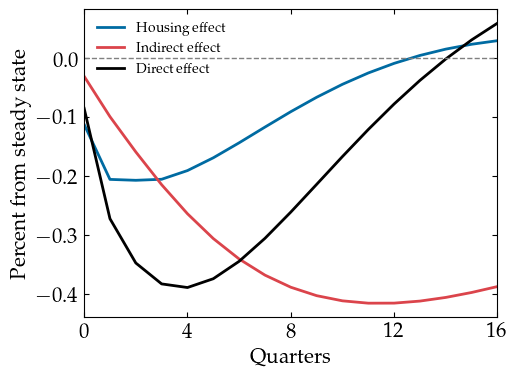

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(16*1/3,4), sharey=True)

plot_total = False

ii = 0
ax.plot(100*qh_baseline[:H]/model['baseline']['C_BHAT'], label='Housing effect')
ax.plot(100*indirect_baseline[:H]/model['baseline']['C_BHAT'], label='Indirect effect')
ax.plot(100*direct_baseline[:H]/model['baseline']['C_BHAT'], label='Direct effect')

if plot_total:
    ax.plot(100*tot_baseline[:H], label='Total (for check)')
    ax.plot(100*(irfs['inatt']['C_BHAT'][:H]), ls = '--', linewidth=2)

# ax.set_title('Consumption Decomposition')
ax.set_xlabel('Quarters')
ax.set_ylabel('Percent from steady state')
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.set_xlim(0, 16)
ax.axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax.legend(fontsize=10, frameon=False) #, loc='center right', bbox_to_anchor=(1, 0.44)

# ax.plot(100*decomp.baseline.dC_dN[:H]/model['baseline']['C_BHAT'], label=r'Hours ($N$)')
# ax.plot(100*decomp.baseline.dC_dTax[:H]/model['baseline']['C_BHAT'], label=r'Tax ($\tau$)')
# ax.plot(100*decomp.baseline.dC_dDiv[:H]/model['baseline']['C_BHAT'], label=r'Dividends ($d$)')
# ax.plot(100*decomp.baseline.dC_dw[:H]/model['baseline']['C_BHAT'], label=r'Wage ($w$)')
# # ax.set_title('Details of Indirect Effect')
# ax.set_xlabel('Quarters')
# ax.set_ylabel('Percent from steady state')
# ax.xaxis.set_major_locator(MultipleLocator(4))
# ax.set_xlim(0, 16)
# ax.axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
# ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
# ax.legend(fontsize=10, frameon=False, ncols=1, loc='center right', bbox_to_anchor=(1, 0.7))

plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    # fig.savefig(os.path.join(figure_path, 'ConsumptionDecomp_v3.pdf'), dpi=1000, bbox_inches='tight')
    fig.savefig(os.path.join(figure_path, 'ConsumptionDecompIndirect_v3.pdf'), dpi=1000, bbox_inches='tight')

### Numbers for table

In [27]:
print(f"Total cumulative effect: {np.round(100*np.cumsum(tot_baseline/model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]],1)}")
print(f"qh cumulative effect: {np.round(100*np.cumsum(qh_baseline/model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]],1)}")
print(f"indirect cumulative effect: {np.round(100*np.cumsum(indirect_baseline/model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]],1)}")
print(f"Direct cumulative effect: {np.round(100*np.cumsum(direct_baseline/model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]],1)}")

Total cumulative effect: [-0.2 -2.3 -5.6 -8.3 -9.9]
qh cumulative effect: [-0.1 -0.7 -1.4 -1.6 -1.5]
indirect cumulative effect: [-0.  -0.5 -1.8 -3.4 -5. ]
Direct cumulative effect: [-0.1 -1.1 -2.5 -3.3 -3.4]


In [28]:
# print(f"Total cumulative effect: {np.round(100*np.cumsum(tot_baseline/model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]],1)}")
print(f"qh cumulative effect: {np.round(100*qh_hw_cum[[0, 3, 7, 11, 15]],0)}")
print(f"indirect cumulative effect: {np.round(100*indirect_hw_cum[[0, 3, 7, 11, 15]],0)}")
print(f"Direct cumulative effect: {np.round(100*direct_hw_cum[[0, 3, 7, 11, 15]],0)}")

qh cumulative effect: [43. 27. 18. 12.  8.]
indirect cumulative effect: [13. 20. 29. 38. 47.]
Direct cumulative effect: [44. 53. 53. 50. 45.]


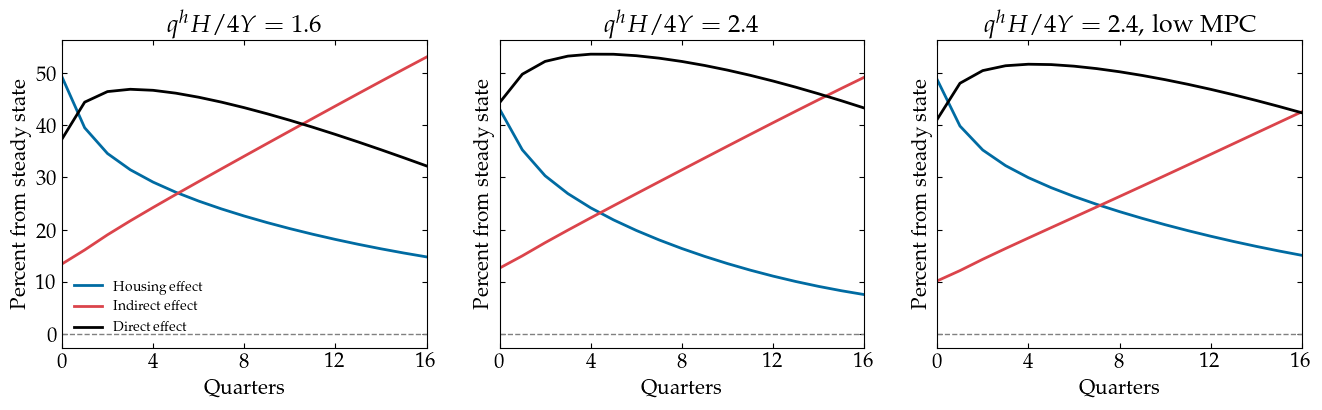

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(16*3/3,4), sharey=True)
ax = ax.flatten()
plot_total = False

ii = 0
ax[ii].plot(100*qh_baseline_cum[:H], label='Housing effect')
ax[ii].plot(100*indirect_baseline_cum[:H], label='Indirect effect')
ax[ii].plot(100*direct_baseline_cum[:H], label='Direct effect')

ii += 1
ax[ii].plot(100*qh_hw_cum[:H], label='Housing effect')
ax[ii].plot(100*indirect_hw_cum[:H], label='Indirect effect')
ax[ii].plot(100*direct_hw_cum[:H], label='Direct effect')

ii += 1
ax[ii].plot(100*qh_diffmpc_cum[:H], label='Housing effect')
ax[ii].plot(100*indirect_diffmpc_cum[:H], label='Indirect effect')
ax[ii].plot(100*direct_diffmpc_cum[:H], label='Direct effect')

titles = [r'$q^hH/4Y = 1.6$',r'$q^hH/4Y = 2.4$', r"$q^hH/4Y = 2.4$, low MPC"]
for ii in range(3):
    ax[ii].set_xlabel('Quarters')
    ax[ii].set_ylabel('Percent from steady state')
    ax[ii].xaxis.set_major_locator(MultipleLocator(4))
    ax[ii].set_xlim(0, 16)
    ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
    ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    if ii == 0:
        ax[ii].legend(fontsize=10, frameon=False)
    ax[ii].set_title(titles[ii])

# 4. -- Figures for state dependence -- 

### Figure 1: Effects across different wealth levels

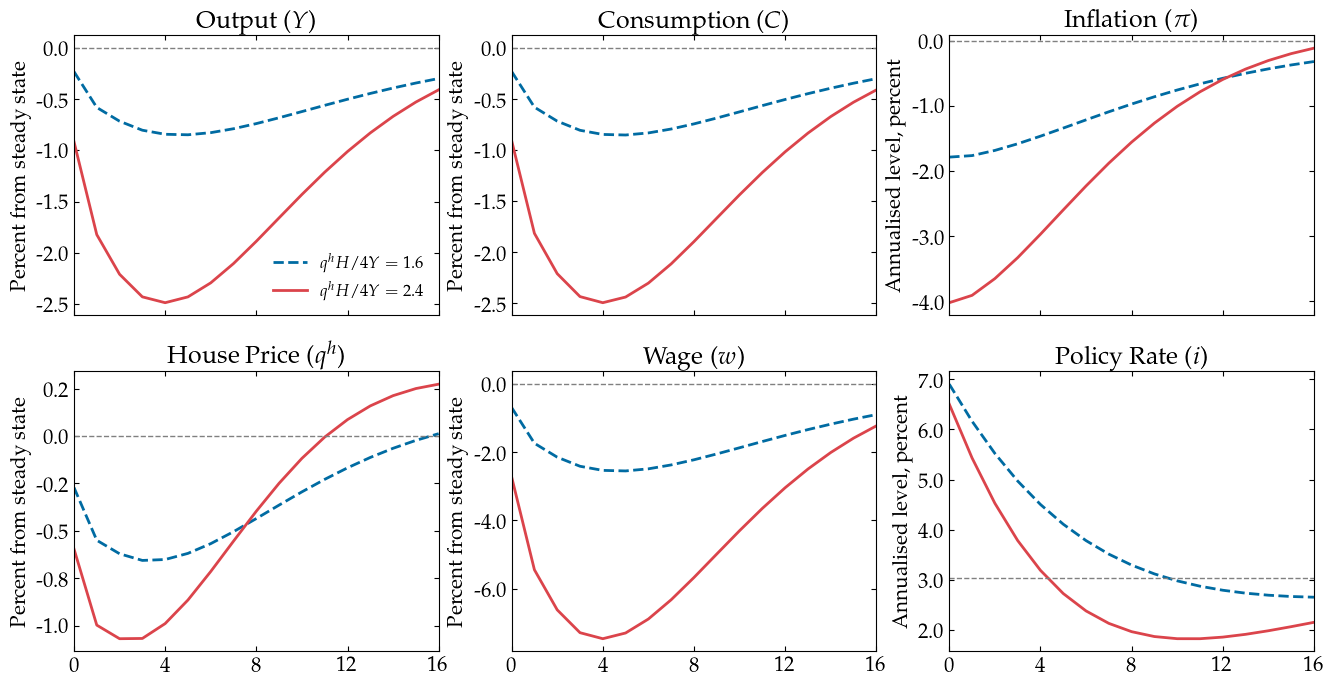

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(16,12*2/3), sharex = True)
ax = ax.flatten()

irf1 = irfs['inatt']
irf2 = irfs['inatt_hw']
model_ss = model['baseline']
model_highwealth = model['qh10']

var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'pi': r'Inflation ($\pi$)', 
            'qh': r'House Price ($q^h$)','w': r'Wage ($w$)', 'i': r'Policy Rate ($i$)'}

for i, (key, value) in enumerate(var_name.items()):   
    if key in devss:   
        ax[i].plot(100*(irf1[key][:H]/model_ss[key]), linewidth=2, linestyle='--')
        ax[i].plot(100*(irf2[key][:H]/model_highwealth[key]), linewidth=2)
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + model_ss[key] +irf1[key][:H])**4-1), linewidth=2, linestyle='--')
        ax[i].plot(100*((1 + model_highwealth[key] +irf2[key][:H])**4-1), linewidth=2)
        ax[i].axhline(y=100*((1 + model_ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    if i == 0:
        ax[i].legend([r'$q^hH/4Y = 1.6$',r'$q^hH/4Y = 2.4$'], fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1)
    
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'StateDependence_v3.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Figure 2: Decomposing the effect

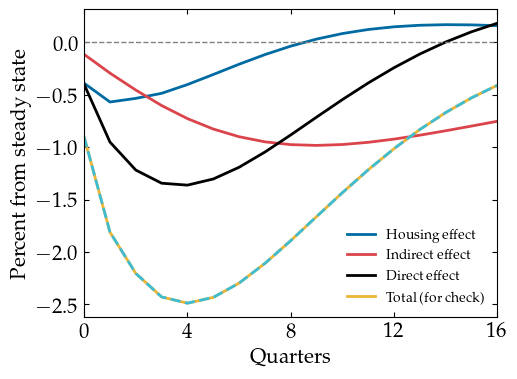

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(16*1/3,4), sharey=True)
plot_total = True

ii = 0
ax.plot(100*qh_hw[:H]/model['qh10']['C_BHAT'], label='Housing effect')
ax.plot(100*indirect_hw[:H]/model['qh10']['C_BHAT'], label='Indirect effect')
ax.plot(100*direct_hw[:H]/model['qh10']['C_BHAT'], label='Direct effect')

if plot_total:
    ax.plot(100*tot_hw[:H], label='Total (for check)')
    ax.plot(100*(irfs['inatt_hw']['C_BHAT'][:H]), ls = '--', linewidth=2)

# ax.set_title('Consumption Decomposition')
ax.set_xlabel('Quarters')
ax.set_ylabel('Percent from steady state')
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.set_xlim(0, 16)
ax.axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax.legend(fontsize=10, frameon=False) #, loc='center right', bbox_to_anchor=(1, 0.44)

### Figure 3. Housing wealth elasticity for different levels of wealth

Mean MPC: 0.018
Mean MPC: 0.013


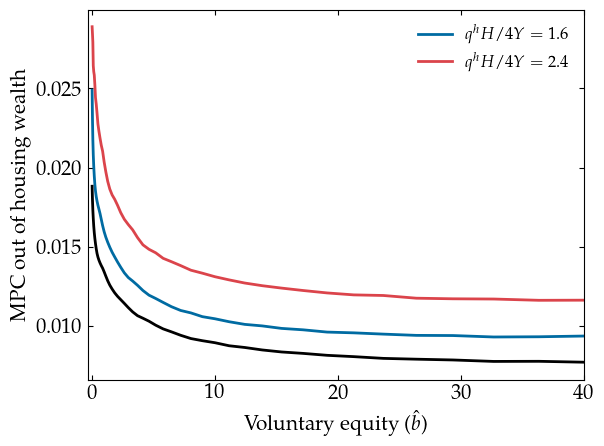

In [32]:
MPCH_hw, mean_MPC = utils.calc_mpch(model['qh10'], hh_name)
print(f"Mean MPC: {mean_MPC:.3f}")
MPCH_diffmpc, mean_MPC = utils.calc_mpch(model['diffmpc'], hh_name)
print(f"Mean MPC: {mean_MPC:.3f}")

z_idx = 1
h_idx = 10
b_idx = 10

def format_func(value, tick_number):
    return f'{value:.3f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

fig, ax = plt.subplots()
ax.plot(b_grid, MPCH[z_idx,:,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
ax.plot(b_grid, MPCH_hw[z_idx,:,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
ax.plot(b_grid, MPCH_diffmpc[z_idx,:,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax.set_xlabel(r'Voluntary equity ($\hat{b}$)')
ax.set_ylabel('MPC out of housing wealth')
ax.legend([r'$q^hH/4Y = 1.6$',r'$q^hH/4Y = 2.4$'], fontsize=12, frameon=False)
ax.set_xlim(-0.35, 40)
ax.yaxis.set_major_formatter(formatter)
# ax.grid(True, axis='y')
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'MPCH_differentWealth.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Figure 4. Allowing the average MPC to vary

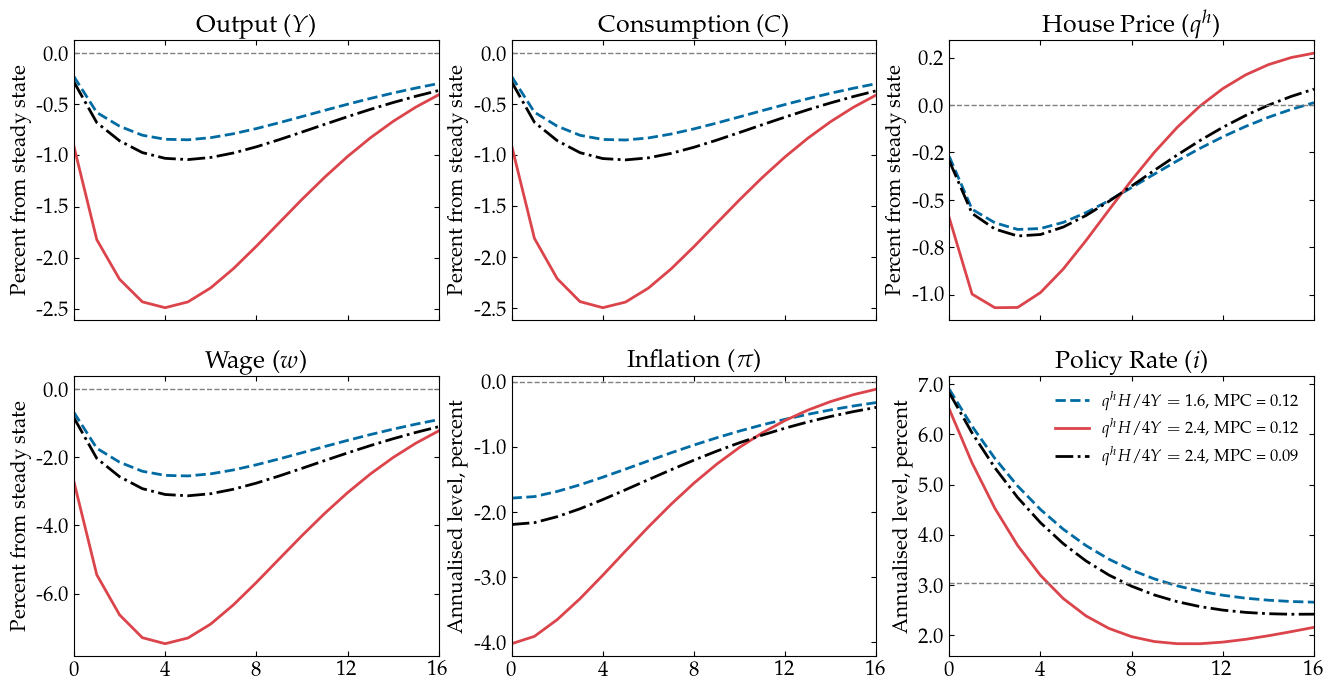

In [33]:
plt.rcParams['lines.linewidth'] = 2.5
fig, ax = plt.subplots(2, 3, figsize=(16,12*2/3), sharex = True)
ax = ax.flatten()

irf1 = irfs['inatt']
irf2 = irfs['inatt_hw']
irf3 = irfs['diff_mpc']
model_ss = model['baseline']
model_highwealth = model['qh10']
model_diffmpc = model['diffmpc']

var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'qh': r'House Price ($q^h$)',
            'w': r'Wage ($w$)', 'pi': r'Inflation ($\pi$)', 'i': r'Policy Rate ($i$)'}

def format_func(value, tick_number):
    return f'{value:.1f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

for i, (key, value) in enumerate(var_name.items()):   
    if key in devss:   
        ax[i].plot(100*(irf1[key][:H]/model_ss[key]), linewidth=2, 
                   linestyle='--', label=fr"$q^hH/4Y = 1.6$, MPC = {ss['baseline']['MPC']:.2f}")
        ax[i].plot(100*(irf2[key][:H]/model_highwealth[key]), linewidth=2, 
                   label=fr"$q^hH/4Y = 2.4$, MPC = {ss['qh10']['MPC']:.2f}")
        ax[i].plot(100*(irf3[key][:H]/model_diffmpc[key]), linewidth=2, ls = 'dashdot',
                   label=fr"$q^hH/4Y = 2.4$, MPC = {ss['diffmpc']['MPC']:.2f}")
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + model_ss[key] +irf1[key][:H])**4-1), linewidth=2, linestyle='--',
                   label=fr"$q^hH/4Y = 1.6$, MPC = {ss['baseline']['MPC']:.2f}")
        ax[i].plot(100*((1 + model_highwealth[key] +irf2[key][:H])**4-1), linewidth=2,
                   label=fr"$q^hH/4Y = 2.4$, MPC = {ss['qh10']['MPC']:.2f}")
        ax[i].plot(100*((1 + model_diffmpc[key] +irf3[key][:H])**4-1), linewidth=2, ls = 'dashdot',
                   label=fr"$q^hH/4Y = 2.4$, MPC = {ss['diffmpc']['MPC']:.2f}")

        ax[i].axhline(y=100*((1 + model_ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    if i == 5:
        # ax[i].legend([r'$q^hH/4Y = 1.6$',r'$q^hH/4Y = 2.4$'], fontsize=12, frameon=False)
        ax[i].legend(fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1)
    
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    # fig.savefig(os.path.join(figure_path, 'ConsumptionDecomp_v3.pdf'), dpi=1000, bbox_inches='tight')
    fig.savefig(os.path.join(figure_path, 'ThreeVersionsWealth_v1.pdf'), dpi=1000, bbox_inches='tight')

# 5. -- Not for paper -- 

### Sign effects

In [34]:
irf_nonlin = {}

# sig_r_nonlin = 0.0099
sig_r_nonlin = 0.01/4
dr_nonlin = np.zeros(T)
dr_nonlin[0] = sig_r_nonlin

irf_nonlin['pos'] = hank.solve_impulse_nonlinear(model['baseline'], unknowns, targets, {'epsm': dr_nonlin}, verbose = False)
irf_nonlin['neg'] = hank.solve_impulse_nonlinear(model['baseline'], unknowns, targets, {'epsm': -dr_nonlin}, verbose = False)

Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 2.52E-03
On iteration 1
   max error for i_res is 3.08E-07
On iteration 2
   max error for i_res is 1.13E-10
Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 2.16E-03
On iteration 1
   max error for i_res is 7.64E-07
On iteration 2
   max error for i_res is 3.18E-10
Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 2.17E-03
On iteration 1
   max error for i_res is 7.53E-07
On iteration 2
   max error for i_res is 3.10E-10
Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 2.16E-03
On iteration 1
   max error for i_res is 7.53E-07
On iteration 2
   max error for i_res is 3.10E-10
Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 2.16E-03
On iteration 1
   max error for i_res is 7.53E-07
On iteration 2
   max error for i_res is 3.10E-10
Solving ta

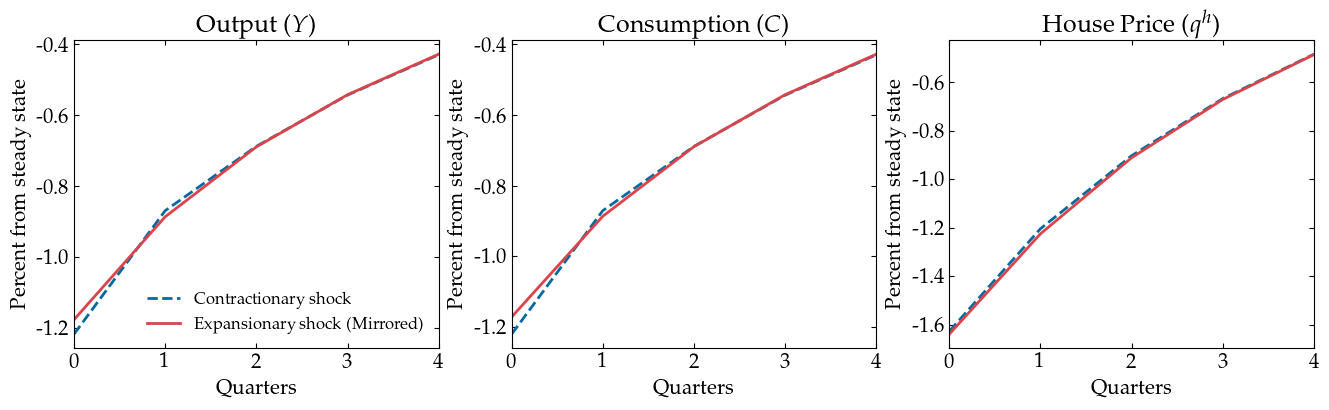

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(16,12*1/3), sharex = True)
ax = ax.flatten()

irf1 = irf_nonlin['pos']
irf2 = irf_nonlin['neg']
model_ss = model['baseline']

var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'qh': r'House Price ($q^h$)'}

def format_func(value, tick_number):
    return f'{value:.1f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

HH = 5
for i, (key, value) in enumerate(var_name.items()):   
    if key in devss:   
        ax[i].plot(100*(irf1[key][:HH]/model_ss[key]), linewidth=2, linestyle='--')
        ax[i].plot(-100*(irf2[key][:HH]/model_ss[key]), linewidth=2)
        # ax[i].plot(100*(irf3[key][:H]/model_hw[key]), linewidth=2)
        # ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + model_ss[key] +irf1[key][:HH])**4-1), linewidth=2, linestyle='--')
        ax[i].plot(-100*((1 + model_ss[key] +irf2[key][:HH])**4-1), linewidth=2)
        # ax[i].axhline(y=100*((1 + model_ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    if i == 0:
        ax[i].legend(['Contractionary shock',fr'Expansionary shock (Mirrored)'], fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(1))
    ax[i].set_xlim(0, HH -1)
    ax[i].set_xlabel('Quarters')
    
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'SignEffects25bps_v001.pdf'), dpi=1000, bbox_inches='tight')

# 6. Comparing with old model

In [58]:
hh = hh_housing_v3.hh_housecons_sep_old
hh1 = hh.add_hetinputs([utils.make_grids_old, utils.income_old])
hh2_old = hh1.add_hetoutputs([utils.compute_mpc])
hh_name_old = hh.name

blocks_ss = [hh2_old, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
            utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]

hank_ss_old = create_model(blocks_ss, name="Housing HANK SS")

blocks = [hh2_old, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
            utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]

hank_old = create_model(blocks, name="Housing HANK")

In [59]:
real_rigid = 5
calvo_keep = 0.75 #0.926
calvo_change = 1 - calvo_keep

beta = model['baseline']['omega'] * model['baseline']['beta_hi'] +\
      (1 - model['baseline']['omega']) * (model['baseline']['beta_hi'] - model['baseline']['dbeta'])

kappa = 1 / (1 + real_rigid) * (calvo_change * (1 - beta*calvo_keep)/(calvo_keep))

In [60]:
cali_main_old = {'gamma': 0.8, 'qh': 1.61*4, 'sigma': 2.0, 'alpha': 0.05, 'bmax': 45, 'rhom': 0.89,
                'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'epsm': 0.0,
                'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
                'kappa': 0.01, 'rstar': 0.03/4, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}

cali_main_old['kappa'] = 0.1 #kappa
cali_main_old['alpha'] = 0.0


unknowns_ss_old = {'beta': 0.970, 'varphi': 0.836, 'theta': 0.061}
targets_ss_old = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss['old'] = hank_ss_old.solve_steady_state(cali_main_old, unknowns_ss_old, targets_ss_old, solver="hybr")
model['old'] = hank_old.steady_state(ss['old'])

In [61]:
cali_main_old_qh10 = cali_main_old.copy()
cali_main_old_qh10['qh'] = 2.4*4
ss['old_qh10'] = hank_ss_old.solve_steady_state(cali_main_old_qh10, unknowns_ss_old, targets_ss_old, solver="hybr")
model['old_qh10'] = hank_old.steady_state(ss['old_qh10'])

In [63]:
print(f"beta: {ss['old']['beta']:.3f}, theta: {ss['old']['theta']:.3f}, varphi: {ss['old']['varphi']:.3f}, MPC: {ss['old']['MPC']:.3f}")
print(f"beta: {ss['old_qh10']['beta']:.3f}, theta: {ss['old_qh10']['theta']:.3f}, varphi: {ss['old_qh10']['varphi']:.3f}, MPC: {ss['old_qh10']['MPC']:.3f}")

beta: 0.954, theta: 0.051, varphi: 0.833, MPC: 0.083
beta: 0.964, theta: 0.075, varphi: 0.833, MPC: 0.060


In [41]:
cali_compare= {'gamma': 0.8, 'qh': 1.61*4, 'sigma': 2.0, 'alpha': 0.05, 'bmax': 45, 'rhom': 0.89, 'q': 0, 'dbeta': 0.0,
                'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'epsm': 0.0, 'omega': 0.0,
                'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
                'kappa': 0.01, 'rstar': 0.03/4, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}

cali_compare['kappa'] = kappa

unknowns_ss_compare = {'beta_hi': 0.970, 'varphi': 0.836, 'theta': 0.061}
targets_ss_compare = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss['compare_old'] = hank_ss.solve_steady_state(cali_compare, unknowns_ss_compare, targets_ss_compare, solver="hybr")
model['compare_old'] = hank.steady_state(ss['compare_old'])

print(f"beta_hi: {ss['compare_old']['beta_hi']:.3f}, theta: {ss['compare_old']['theta']:.3f}, varphi: {ss['compare_old']['varphi']:.3f}")

beta_hi: 0.954, theta: 0.054, varphi: 0.834


In [65]:
sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r

Js_dict = {}

xi = 0.99 # persistence of expectations
irfs['old'], Js_dict['old'] = inattention_irf(xi, model['old'], hh2_old, hank_old, hh_name_old, 
                              input_list, output_list, unknowns, targets, dr)
# irfs['compare_old'], _ = inattention_irf(xi, model['compare_old'], hh2, hank, hh_name, 
#                                       input_list, output_list, unknowns, targets, dr)

In [66]:
irfs['old_qh10'], Js_dict['old_qh10'] = inattention_irf(xi, model['old_qh10'], hh2_old, hank_old, hh_name_old, 
                                   input_list, output_list, unknowns, targets, dr)

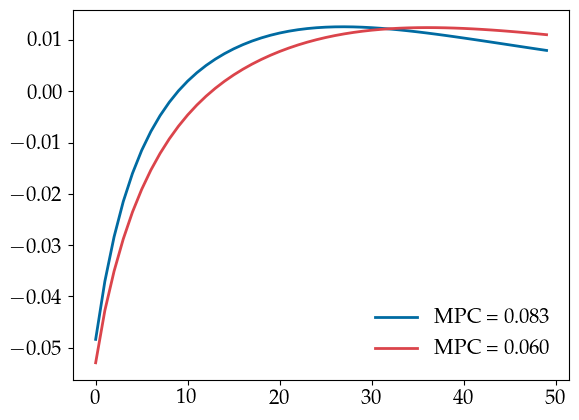

In [69]:
i = 0
H_jac = 50
plt.plot(Js_dict['old'][hh_name_old]['C_BHAT']['r'][:H_jac,i], label = f"MPC = {ss['old']['MPC']:.3f}")
plt.plot(Js_dict['old_qh10'][hh_name_old]['C_BHAT']['r'][:H_jac,i], label = f"MPC = {ss['old_qh10']['MPC']:.3f}")
plt.legend(frameon=False)

In [ ]:
sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r

xi = 0.99 # persistence of expectations

model_ss = model['old'] # steady state for qh = (baseline)
model_hw = model['compare_old'] # steady state for qh = 10

Js = {hh_name: hh2_old.jacobian(model_ss, inputs=input_list, outputs=output_list, T=T)}
Js_hw = {hh_name_old: hh2.jacobian(model_hw, inputs=input_list, outputs=output_list, T=T)}

jac_ = manipulate_jac(xi, Js, input_list, output_list, hh_name)
jac_hw = manipulate_jac(xi, Js_hw, input_list, output_list, hh_name_old)

Js_myopic = {hh_name: JacobianDict(jac_, inputs=input_list, outputs=output_list, name='hank')}
Js_myopic_hw = {hh_name_old: JacobianDict(jac_hw, inputs=input_list, outputs=output_list, name='hank')}

irfs['old'] = (hank_old.solve_jacobian(model_ss, unknowns=unknowns, targets=targets, T=T,
                                              Js=Js_myopic, inputs=['epsm'], 
                                              outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

irfs['compare_old'] = (hank.solve_jacobian(model_hw, unknowns=unknowns, targets=targets, T=T,
                                              Js=Js_myopic_hw, inputs=['epsm'], 
                                              outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

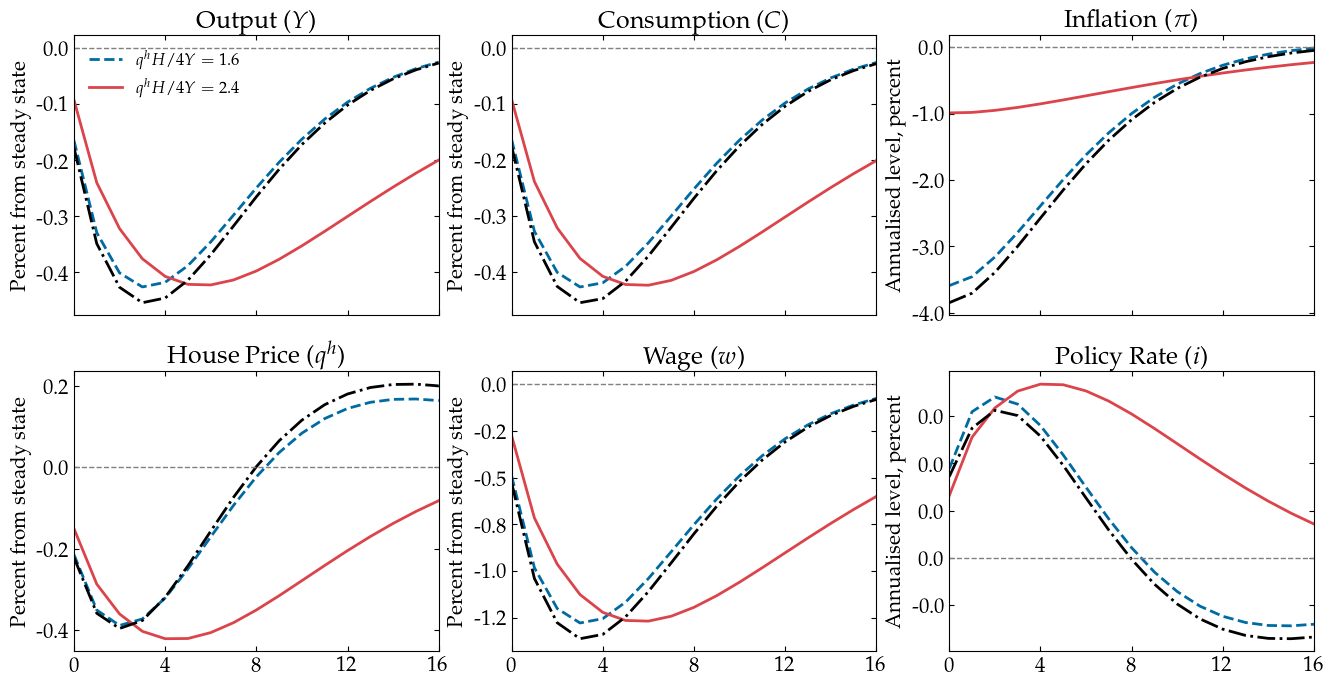

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(16,12*2/3), sharex = True)
ax = ax.flatten()

irf1 = irfs['old']
irf2 = irfs['compare_old']
irf3 = irfs['old_qh10']
model_ss = model['old']
model_highwealth = model['compare_old']
model_hw = model['old_qh10']

var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'pi': r'Inflation ($\pi$)', 
            'qh': r'House Price ($q^h$)','w': r'Wage ($w$)', 'i': r'Policy Rate ($i$)'}

for i, (key, value) in enumerate(var_name.items()):   
    if key in devss:   
        ax[i].plot(100*(irf1[key][:H]/model_ss[key]), linewidth=2, linestyle='--')
        ax[i].plot(100*(irf2[key][:H]/model_highwealth[key]), linewidth=2)
        ax[i].plot(100*(irf3[key][:H]/model_hw[key]), linewidth=2, ls = 'dashdot')
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + model_ss[key] +irf1[key][:H])**4-1), linewidth=2, linestyle='--')
        ax[i].plot(100*((1 + model_highwealth[key] +irf2[key][:H])**4-1), linewidth=2)
        ax[i].plot(100*((1 + model_hw[key] +irf3[key][:H])**4-1), linewidth=2, ls = 'dashdot')
        ax[i].axhline(y=100*((1 + model_ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    if i == 0:
        ax[i].legend([r'$q^hH/4Y = 1.6$',r'$q^hH/4Y = 2.4$'], fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1)
    
plt.show()

In [73]:
c_decomp = {}
c_decomp['old'] = consumption_decomp(Js_dict['old'], irfs['old'], hh_name_old)
c_decomp['old_qh10'] = consumption_decomp(Js_dict['old_qh10'], irfs['old_qh10'], hh_name_old)

In [83]:
def plot_decomp(nrows, ncols, decomp_dict, irfs, H = 17, plot_together = False):
    fig, ax = plt.subplots(nrows, ncols, figsize=(16*ncols/3,12*nrows/3), sharex = True, sharey = True)

    if nrows == 1 and ncols == 1:
        ax = ax.flatten()

    plot_total = False

    ii = 0
    for key, value in decomp_dict.items():
        ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], label='Housing effect')
        ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], label='Indirect effect')
        ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], label='Direct effect')
        ax[ii].set_title(key)

        ax[ii].set_xlabel('Quarters')
        ax[ii].set_ylabel('Percent from steady state')
        ax[ii].xaxis.set_major_locator(MultipleLocator(4))
        ax[ii].set_xlim(0, 16)
        ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
        ax[ii].legend(fontsize=10, frameon=False) #, loc='center right', bbox_to_anchor=(1, 0.44)

        ii += 1

    if plot_together:
        jj = 0
        
        for key, value in decomp_dict.items():
            if jj == 0:
                ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], label=f'{key}', color = '#006BA2')
                ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], label=f'{key}', color = '#DB444B')
                ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], label=f'{key}', color = '#000000')
            else: 
                ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], color = '#006BA2', ls = 'dashdot', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], color = '#DB444B', ls = 'dashdot', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], color = '#000000', ls = 'dashdot', label=f'{key}')

            jj += 1
            ax[ii].legend(fontsize=10, frameon=False, ncols = 2)
            ax[ii].set_title('Comparision')

    plt.show()

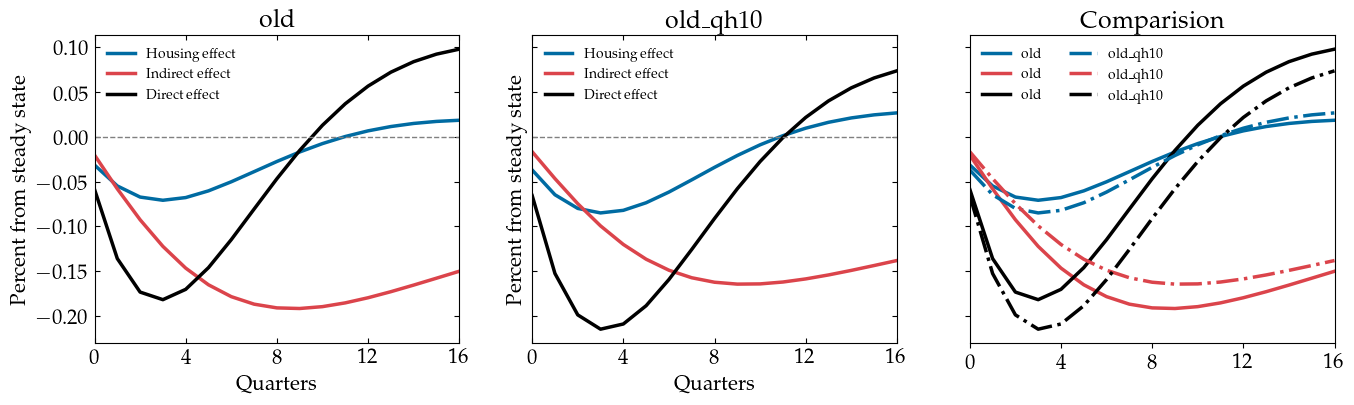

In [84]:
plot_decomp(1, 3, c_decomp, model, H = 17, plot_together=True)